In [1]:
import sys
sys.path.insert(0, '../')
from lib import *

%matplotlib inline

DEBUG = False;

SER run:
Run                                                             22
Channels                                           [0, 1, 3, 4, 5]
Polarity                        {0: -1, 1: -1, 3: -1, 4: -1, 5: 1}
Type                                                       Visible
ChannelName         [SiPM289, SiPM290, SiPM377, SiPM378, XARAPUCA]
OverVoltageSiPMs                                                 4
OverVoltageXA                                                    7
Threshold                                                      NaN
Nev                                                          50127
Duration                                                    108.48
Rate                                                       462.084
Date                                           1969-12-31 18:00:45
Name: 22, dtype: object


Calib run:
Run                                                              7
Channels                                           [0, 1, 3, 4, 5]
Polarity        

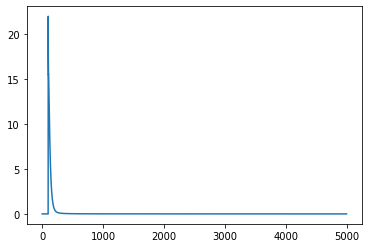

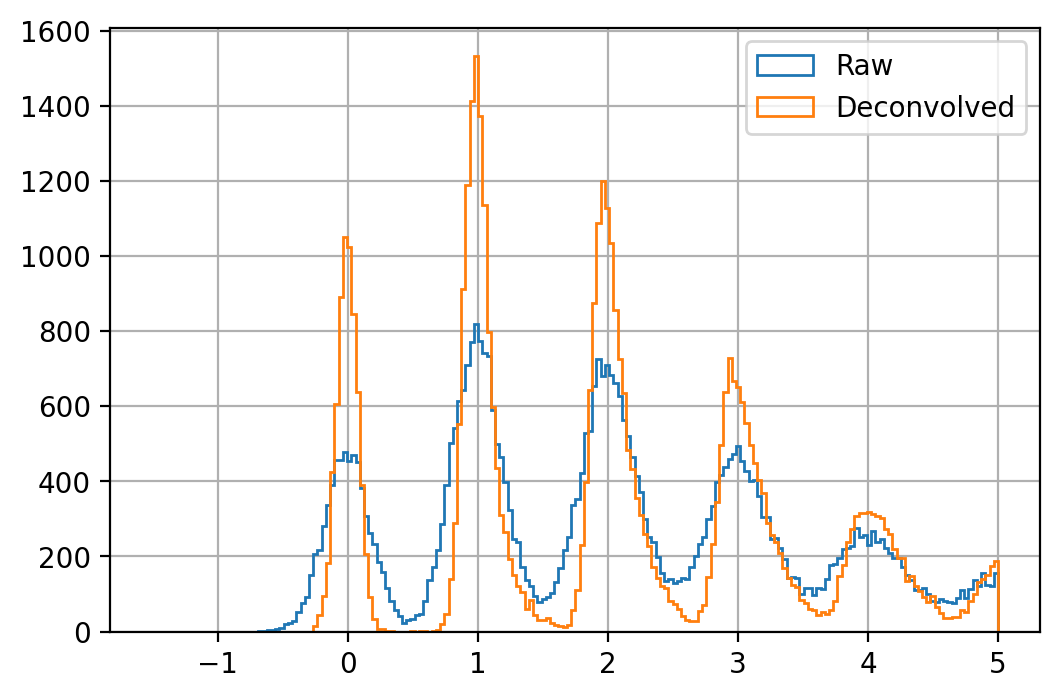

In [7]:
WEEK="DAPHNE_VUV";
# WEEK="DAPHNE_VIS";
compress=False

OV=4
CH=0

path="/scr/neutrinos/rodrigoa/"+WEEK+"/joython/"
Runs=open_runs_table("../macros/"+WEEK+".xlsx")

Light_run=Runs[(Runs["Type"]=="Visible")     & ( Runs["OverVoltageSiPMs"]==OV)].iloc[0] #1st run, lower intensity 
Calib_run=Runs[(Runs["Type"]=="Calibration") & ( Runs["OverVoltageSiPMs"]==OV)].iloc[0] #1st run, lower intensity 

if DEBUG:
    print("SER run:")
    print(Light_run)
    print("\n")
    print("Calib run:")
    print(Calib_run)

ADCsxticks2PE=GetGains(WEEK,CH,OV)

#SER Template:
for ch, run in [(0,24)]:
    run_path=path+"run"+str(run).zfill(2)+"/";
    Average_waveform  =open_ch_var(run_path ,"Avg_wvf"   ,ch,compressed=compress)
    XA_SER=Average_waveform["AvWvf_Center_Rise"]
    
    #remove unphysical pretrigger
    presig=100
    XA_SER=np.concatenate([XA_SER[np.argmax(XA_SER)-presig:],np.zeros(XA_SER[:np.argmax(XA_SER)-presig].shape[0])])
    
    XA_SER/=np.sum(XA_SER[0:1000][XA_SER[0:1000]>0]) #normalize area to 1
    XA_SER*=1/ADCsxticks2PE #normalize area to 1 PE
    XA_SER*=1.04
    
    XA_SER_FFT  =np.fft.rfft(XA_SER) 
    gauss_F=gauss(np.arange(len(XA_SER_FFT)),sigma=100,n=2);

    if DEBUG:
        print(np.sum(XA_SER[0:1000][XA_SER[0:1000]>0]))
        plt.plot(XA_SER)

DEBUG=True
#Calibration check:
if DEBUG:
    for ch, run in [(CH,Calib_run["Run"])]:
        run_path=path+"run"+str(run).zfill(2)+"/";
        Charge_vars   = open_ch_var(run_path ,"Charge_vars"   ,ch,compressed=compress)
        Peak_vars     = open_ch_var(run_path  ,"Peak_vars"   ,ch,compressed=compress)
        Pedestal_vars = open_ch_var(run_path  ,"Pedestal_vars_SW"   ,ch,compressed=compress)

        plt.figure(dpi=200)
        #plot charge distribution from raw calibration data
        for charge in ["ChargeRangeAverageWvf"]:
            print(charge)
        
            hist=plt.hist(Charge_vars[charge]*ADCsxticks2PE,bins=200,range=(-1.5,5),histtype="step",label="Raw")
            # plt.hist(Charge_vars[charge][(Peak_vars["PeakTime"]>950)*(Peak_vars["PeakTime"]<1100)]*ADCsxticks2PE,bins=200,range=(0,5),histtype="step",label="Raw+cuts")

        # Compute same charge distribution from deconvolved data
        RawADC=open_ch_var(run_path,"RawADC",ch,compressed=True)
        ADC=substract_Pedestal((RawADC,Pedestal_vars,1))
        del RawADC
        ADC_dec=deconvolve(ADC,XA_SER,gauss_F)
        del ADC


        Pedestal_vars_SW = compute_Pedestal_slidingWindows(ADC_dec)
        ADC_dec          = substract_Pedestal((ADC_dec,Pedestal_vars_SW,-1))
        # Peak_vars        = compute_Peak(ADC_dec)
        
        Charge_vars_dec =np.sum(ADC_dec[:,930:1000],axis=1)

        ped_CUT  = Pedestal_vars_SW["STD"]<(np.mean(Pedestal_vars_SW["STD"])+2*np.std(Pedestal_vars_SW["STD"]))
        
        hist_dec=plt.hist(Charge_vars_dec           ,bins=200,range=(-1.5,5),histtype="step",label="Deconvolved")
        # plt.hist(Charge_vars_dec[Peak_vars["PeakTime"]<1071]           ,bins=200,range=(-1.5,5),histtype="step",label="Deconvolved+CUTs")
        plt.legend()

        # plt.semilogy()
        plt.grid()


## Fit

In [8]:
def gauss(x,a,x0,sigma):
    return a*np.exp(-0.5*np.power((x-x0)/sigma,2))

def gaussian_train(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        height = params[i]
        center = params[i+1]
        width  = params[i+2]
        y      +=  gauss(x, height, center, width)
    return y

def fit_gaussians(x, y, *p0):
    assert x.shape == y.shape, "Input arrays must have the same shape."
    # try:
    popt, pcov = curve_fit(gaussian_train, x,y, p0=p0[0])
    fit_y=gaussian_train(x,*popt)
    chi_squared = np.sum((y[abs(fit_y)>0.1] - fit_y[abs(fit_y)>0.1]) ** 2 / fit_y[abs(fit_y)>0.1]) / (y.size - len(popt))
    plt.figure(dpi=200, figsize=(4, 6))
    fig = plt.axes()
    plt.plot(x, y, 'b-', label='data')
    plt.plot(x, fit_y, 'r-', label='fit',linewidth=1)
    plt.grid()
    
    #errors:
    error=np.sqrt(np.diag(pcov))
    return popt,fig, chi_squared,error




peaks=find_peaks(hist[0],height=300,width=4)


params=np.zeros(len(peaks[0])*3)
params[0::3]=peaks[1]["peak_heights"]
params[1::3]=hist[1][peaks[0]]
params[2::3]=.1
vars,fig,qs,errors=fit_gaussians(hist[1][:-1],hist[0],params)

fig.set_xlabel("Charge [A.U.]")
fig.set_ylabel("Counts")
fig.legend(["Data","Fit"],loc="upper right")

plt.ylim(1,2000)

print(vars  [3:6])
print(errors[3:6])

print(np.array(errors[3:6])/np.array(vars[3:6])*100)

print(vars)


NameError: name 'hist' is not defined